# Random Act of Pizza
# Group: Tian Zhu, Yucheng Liu

> In this notebook we are going to go through the following sections to reach our final model

> The first section discusses the different ways of loading and splitting the data

> The second sections discusses the data explorations

> The third sections discusses the feature engineering

> The subsequent sections discuss the different approaches of creating the models with numerica/text data

> The final section discusses the ensemble of models

In [165]:
import json
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from nltk import sent_tokenize
import nltk
nltk.download('punkt')
from copy import deepcopy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from xgboost import XGBClassifier
import re
import seaborn as sns
# General libraries.
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpl
# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

from wordcloud import WordCloud, STOPWORDS

from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline


[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load data

In [456]:
# Load Train Data
dataset = pd.read_json("train.json")
# Load Test Data
sample_data = pd.read_json("test.json")
print("Dataset Shape:", dataset.shape)
print("Sample Shape:", sample_data.shape)
SEED = 0
train, test = train_test_split(dataset, test_size=0.2, random_state=SEED)

Dataset Shape: (4040, 32)
Sample Shape: (1631, 17)


# Optional: Train test split based on time

In [441]:
time_sorted_data = dataset.sort_values(by=['unix_timestamp_of_request'])
train_80_loc = int(len(time_sorted_data)/10*8)
train = time_sorted_data.iloc[:train_80_loc, :]
test = time_sorted_data.iloc[train_80_loc:, :]

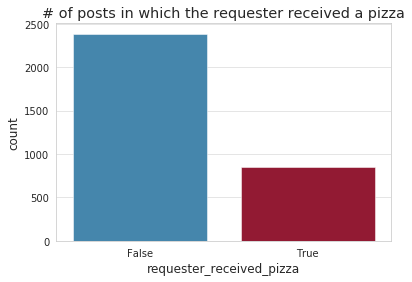

In [442]:
(sns.countplot(x = train.requester_received_pizza).
set_title("# of posts in which the requester received a pizza"));

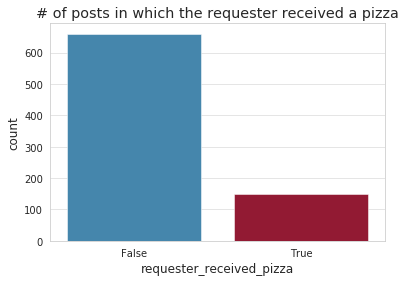

In [443]:
(sns.countplot(x = test.requester_received_pizza).
set_title("# of posts in which the requester received a pizza"));

# Original data without balancing for labels
> this is an attempt to split the train/test based on time

> this will allow a more realistic perspective of the model on future data

> the rest of the sections will assume that this section was skipped

In [457]:
# original data
# we can use this data for analysis purposes
train_data = train[train.columns.intersection(sample_data.columns)]
train_labels = train[['requester_received_pizza']]
train_all_labels = train[train.columns.difference(sample_data.columns)]
test_data = test[test.columns.intersection(sample_data.columns)]
test_labels = test[['requester_received_pizza']]
test_all_labels = test[test.columns.difference(sample_data.columns)]
print("Train data shape:",train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (3232, 17)
Test data shape: (808, 17)


# Data balanced for labels
> balances the data to have 50/50 split of true/false outcomes

In [458]:
# try balanced data instead
# this data can be used for 
train_positive = train[train['requester_received_pizza']==1]
train_negative = train[train['requester_received_pizza']==0]
true_weight_ratio = 1 + (train_negative['requester_received_pizza'].count() - train_positive['requester_received_pizza'].count())/(train_positive['requester_received_pizza'].count())
train_positive_balanced = train_positive.sample(frac=true_weight_ratio, replace=True, random_state=SEED)
train_balanced = pd.concat([train_positive_balanced, train_negative])

train_data = train_balanced[train_balanced.columns.intersection(sample_data.columns)]
train_labels = train_balanced[['requester_received_pizza']]
train_all_labels = train_balanced[train_balanced.columns.difference(sample_data.columns)]
test_data = test[test.columns.intersection(sample_data.columns)]
test_labels = test[['requester_received_pizza']]
test_all_labels = test[test.columns.difference(sample_data.columns)]
print("Train data shape:",train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (4888, 17)
Test data shape: (808, 17)


# Data Exploration
> explore both the train/test data

In [128]:
# simple summary of the train data
train_data_summary = train_data.describe(include='all', datetime_is_numeric=True)
train_data_summary.transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
giver_username_if_known,4888,194,N/A,4188,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_id,4888,3199,t3_pa5of,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_text_edit_aware,4888,3110,,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_title,4888,3188,[REQUEST]Need something to hold me over until ...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requester_account_age_in_days_at_request,4888.0,NaN,NaN,NaN,263.047387,304.572023,0.0,16.928573,168.355116,392.910712,2809.750787
requester_days_since_first_post_on_raop_at_request,4888.0,NaN,NaN,NaN,22.395692,86.260049,0.0,0.0,0.0,0.0,785.457685
requester_number_of_comments_at_request,4888.0,NaN,NaN,NaN,120.655483,200.829541,0.0,0.0,28.0,149.0,992.0
requester_number_of_comments_in_raop_at_request,4888.0,NaN,NaN,NaN,0.940876,4.618623,0.0,0.0,0.0,0.0,88.0
requester_number_of_posts_at_request,4888.0,NaN,NaN,NaN,24.046031,58.009487,0.0,0.0,5.0,22.0,867.0
requester_number_of_posts_on_raop_at_request,4888.0,NaN,NaN,NaN,0.093494,0.423929,0.0,0.0,0.0,0.0,5.0


In [130]:
test_data_summary = test_data.describe(include='all', datetime_is_numeric=True)
test_data_summary.transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
giver_username_if_known,808,58,N/A,750,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_id,808,808,t3_1ih7n3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_text_edit_aware,808,790,,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
request_title,808,807,[REQUEST],2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requester_account_age_in_days_at_request,808.0,NaN,NaN,NaN,263.001466,303.38354,0.0,4.243958,169.467633,418.139042,2521.263206
requester_days_since_first_post_on_raop_at_request,808.0,NaN,NaN,NaN,18.131502,75.59019,0.0,0.0,0.0,0.0,711.307627
requester_number_of_comments_at_request,808.0,NaN,NaN,NaN,120.683168,196.713105,0.0,0.0,27.0,149.5,994.0
requester_number_of_comments_in_raop_at_request,808.0,NaN,NaN,NaN,0.636139,2.693566,0.0,0.0,0.0,0.0,47.0
requester_number_of_posts_at_request,808.0,NaN,NaN,NaN,21.433168,50.339029,0.0,0.0,5.0,23.0,824.0
requester_number_of_posts_on_raop_at_request,808.0,NaN,NaN,NaN,0.066832,0.311671,0.0,0.0,0.0,0.0,3.0


In [131]:
train_labels_summary = train_labels.describe(include='all', datetime_is_numeric=True)
train_labels_summary.transpose()

,count,unique,top,freq
requester_received_pizza,4888,2,False,2444


In [132]:
train_all_labels_summary = train_all_labels.describe(include='all', datetime_is_numeric=True)
train_all_labels_summary.transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
number_of_downvotes_of_request_at_retrieval,4888.0,NaN,NaN,NaN,2.404869,2.933467,0.0,1.0,2.0,3.0,47.0
number_of_upvotes_of_request_at_retrieval,4888.0,NaN,NaN,NaN,6.44865,9.828706,0.0,2.0,4.0,7.0,345.0
post_was_edited,4888.0,NaN,NaN,NaN,126340293.94865,394892045.555603,0.0,0.0,0.0,0.0,1380909467.0
request_number_of_comments_at_retrieval,4888.0,NaN,NaN,NaN,3.545622,5.006152,0.0,0.0,2.0,5.0,61.0
request_text,4888,3114,,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
requester_account_age_in_days_at_retrieval,4888.0,NaN,NaN,NaN,779.426539,335.564441,45.291562,541.993782,777.877326,927.098241,2879.276319
requester_days_since_first_post_on_raop_at_retrieval,4888.0,NaN,NaN,NaN,538.170687,267.161725,0.0,304.685324,554.541308,796.502564,927.447442
requester_number_of_comments_at_retrieval,4888.0,NaN,NaN,NaN,308.994681,364.142702,0.0,11.0,138.0,527.25,1000.0
requester_number_of_comments_in_raop_at_retrieval,4888.0,NaN,NaN,NaN,3.555033,7.976474,0.0,0.0,1.0,4.0,139.0
requester_number_of_posts_at_retrieval,4888.0,NaN,NaN,NaN,45.73302,92.956316,0.0,3.0,14.0,48.0,999.0


In [133]:
# check correlation
train_data.corr()

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,unix_timestamp_of_request,unix_timestamp_of_request_utc
requester_account_age_in_days_at_request,1.000000,0.290781,0.469867,0.092597,0.403587,0.106010,0.594926,0.230525,0.096539,0.326364,0.326360
requester_days_since_first_post_on_raop_at_request,0.290781,1.000000,0.258185,0.378419,0.122034,0.375250,0.243950,0.144937,0.106137,0.207576,0.207578
requester_number_of_comments_at_request,0.469867,0.258185,1.000000,0.161788,0.333076,0.142166,0.715004,0.311078,0.110695,0.312597,0.312584
requester_number_of_comments_in_raop_at_request,0.092597,0.378419,0.161788,1.000000,0.022740,0.550553,0.088456,0.172836,0.168239,0.061607,0.061605
requester_number_of_posts_at_request,0.403587,0.122034,0.333076,0.022740,1.000000,0.116508,0.595644,0.448418,0.282481,0.096420,0.096419
requester_number_of_posts_on_raop_at_request,0.106010,0.375250,0.142166,0.550553,0.116508,1.000000,0.122176,0.196138,0.181725,0.128952,0.128950
requester_number_of_subreddits_at_request,0.594926,0.243950,0.715004,0.088456,0.595644,0.122176,1.000000,0.336767,0.140282,0.320726,0.320722
requester_upvotes_minus_downvotes_at_request,0.230525,0.144937,0.311078,0.172836,0.448418,0.196138,0.336767,1.000000,0.945008,0.156865,0.156862
requester_upvotes_plus_downvotes_at_request,0.096539,0.106137,0.110695,0.168239,0.282481,0.181725,0.140282,0.945008,1.000000,0.081171,0.081171
unix_timestamp_of_request,0.326364,0.207576,0.312597,0.061607,0.096420,0.128952,0.320726,0.156865,0.081171,1.000000,1.000000


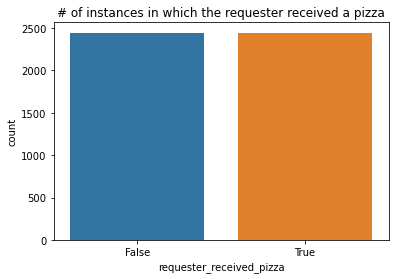

In [136]:
(sns.countplot(x = train_labels.requester_received_pizza).
set_title("# of instances in which the requester received a pizza"));

# Data Transformation
> feature engineering based on understanding of dates, special fields and others

In [401]:
# extract the categorical/numerical fields to be separated from the free text analysis
columns_to_drop = ['giver_username_if_known', 'request_id', 'request_text_edit_aware', 'request_title', 'requester_subreddits_at_request', 'requester_username']
train_data_regression = train_data.drop(columns_to_drop, axis=1)
test_data_regression = test_data.drop(columns_to_drop, axis=1)

In [402]:
# convert time stamp to capture seasonality and time variant
# train_data_regression['year_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).year)
train_data_regression['month_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).month)
train_data_regression['day_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).day)
train_data_regression['hour_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).hour)
train_data_regression['week_day_of_request'] = train_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).weekday())

# test_data_regression['year_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).year)
test_data_regression['month_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).month)
test_data_regression['day_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).day)
test_data_regression['hour_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).hour)
test_data_regression['week_day_of_request'] = test_data_regression['unix_timestamp_of_request_utc'].apply(lambda x: datetime.fromtimestamp(x).weekday())

# drop the timestamp
columns_to_drop = ['unix_timestamp_of_request_utc', 'unix_timestamp_of_request']
train_data_regression = train_data_regression.drop(columns_to_drop, axis=1)
test_data_regression = test_data_regression.drop(columns_to_drop, axis=1)

In [403]:
# add length of the text as a feature
train_data_regression['title_length_char'] = train_data.apply(lambda row: len(row['request_title']), axis=1)
train_data_regression['body_length_char'] = train_data.apply(lambda row: len(row['request_text_edit_aware']), axis=1)
test_data_regression['title_length_char'] = test_data.apply(lambda row: len(row['request_title']), axis=1)
test_data_regression['body_length_char'] = test_data.apply(lambda row: len(row['request_text_edit_aware']), axis=1)

In [404]:
# log all features with non-normal distribution with long tails
columns_with_outlier = ['body_length_char','requester_number_of_subreddits_at_request', 'requester_number_of_comments_at_request', 'requester_account_age_in_days_at_request','requester_days_since_first_post_on_raop_at_request', 'requester_number_of_comments_in_raop_at_request', 'requester_number_of_posts_at_request', 'requester_upvotes_minus_downvotes_at_request', 'requester_upvotes_plus_downvotes_at_request']
for column in columns_with_outlier:
    print(column)
    train_data_regression[column+'_sign'] = train_data_regression.apply(lambda row: 1 if row[column] >= 0 else -1, axis=1)
    test_data_regression[column+'_sign'] = test_data_regression.apply(lambda row: 1 if row[column] >= 0 else -1, axis=1)
    train_data_regression[column] = np.log10(np.abs(train_data_regression[column])+1)*train_data_regression[column+'_sign']
    test_data_regression[column] = np.log10(np.abs(test_data_regression[column])+1)*test_data_regression[column+'_sign']
    train_data_regression = train_data_regression.drop([column+'_sign'], axis=1)
    test_data_regression = test_data_regression.drop([column+'_sign'], axis=1)

body_length_char
requester_number_of_subreddits_at_request
requester_number_of_comments_at_request
requester_account_age_in_days_at_request
requester_days_since_first_post_on_raop_at_request
requester_number_of_comments_in_raop_at_request
requester_number_of_posts_at_request
requester_upvotes_minus_downvotes_at_request
requester_upvotes_plus_downvotes_at_request


## Visualizations of the importance of Time
> we can see that time of the day have a strong correlation with the outcome of interest

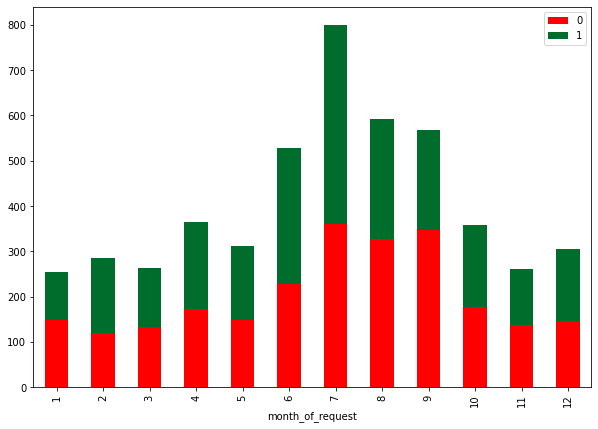

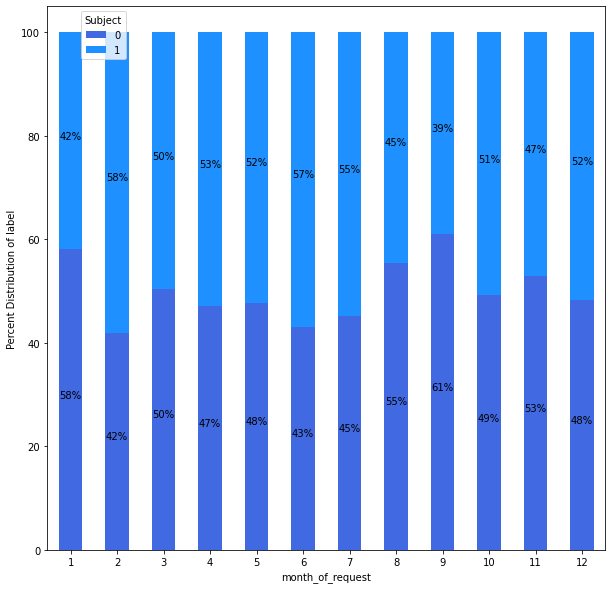

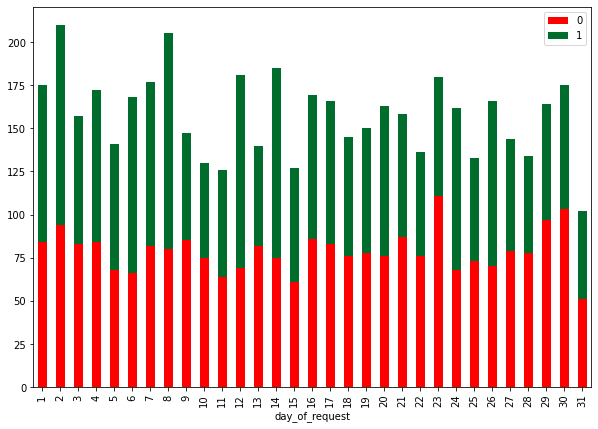

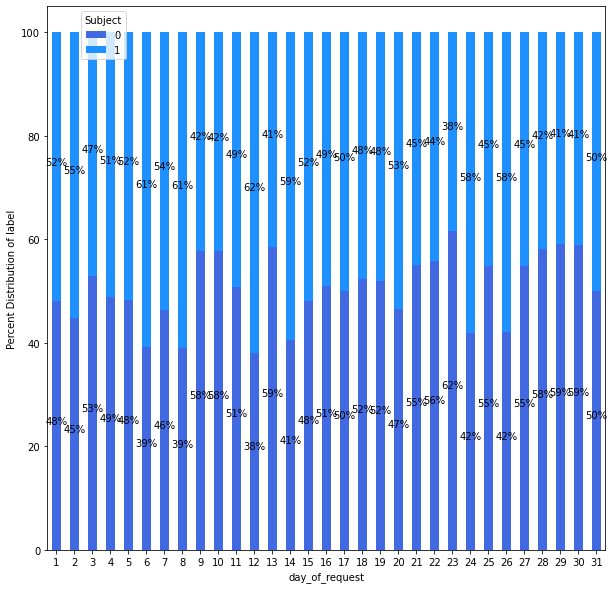

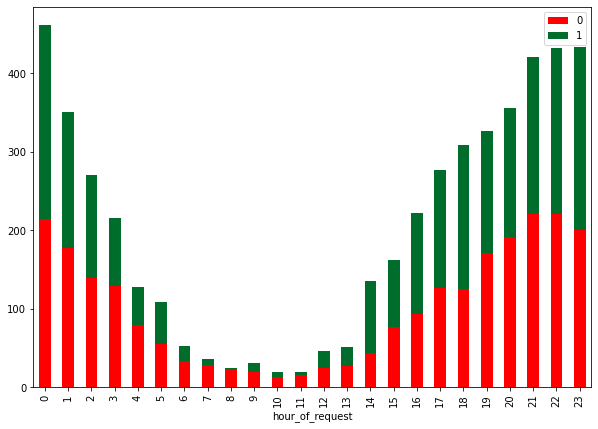

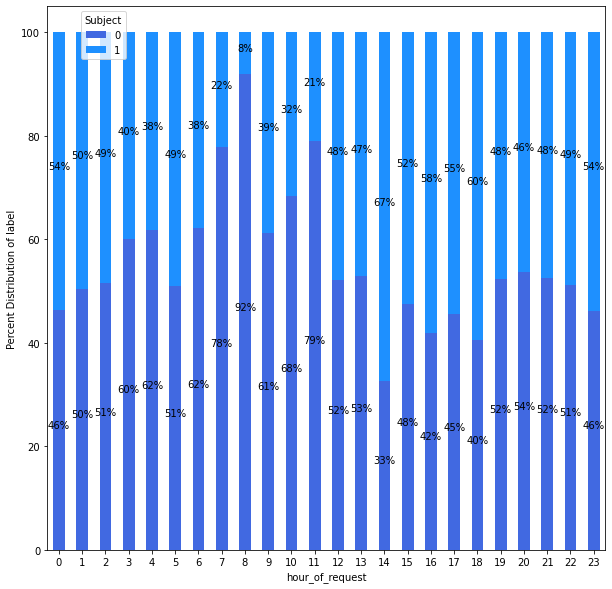

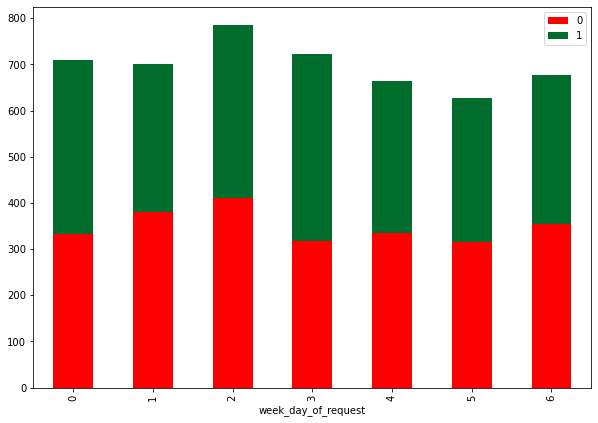

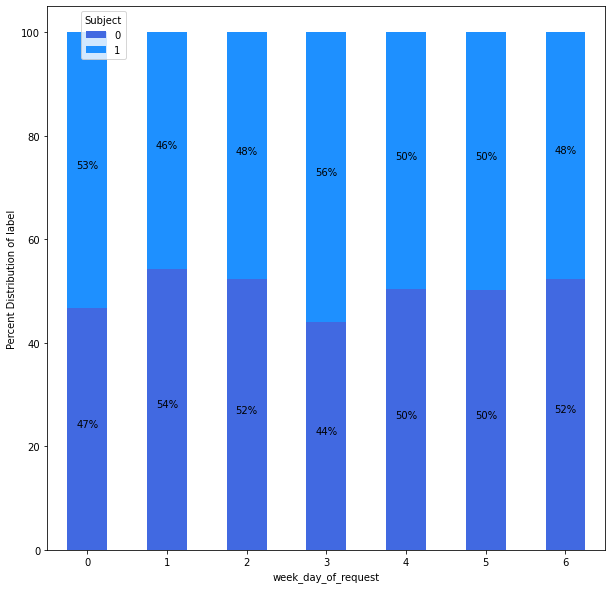

In [142]:
train_data_regression['label'] = train_labels['requester_received_pizza'].astype(int)
column_plot = ['month_of_request','day_of_request','hour_of_request','week_day_of_request']
for var_col in column_plot:
    df= train_data_regression
    df = df.groupby([var_col,'label']).count().reset_index()
    fig, ax = plt.subplots(figsize=(10,7))  

    months = df['label'].drop_duplicates()
    margin_bottom = np.zeros(len(df[var_col].drop_duplicates()))
    colors = ["#FF0000","#006D2C"]
    for num, month in enumerate(months):
        values = list(df[df['label'] == month].loc[:, 'requester_account_age_in_days_at_request'])

        df[df['label'] == month].plot.bar(x=var_col,y='requester_account_age_in_days_at_request', ax=ax, stacked=True, 
                                        bottom = margin_bottom, color=colors[num] ,label=month)
        margin_bottom += values

    plt.show()

    # crosstab
    pal = ["royalblue", "dodgerblue", "lightskyblue", "lightblue"]
    ax= pd.crosstab(train_data_regression[var_col], train_data_regression['label']).apply(lambda r: r/r.sum()*100, axis=1)
    ax_1 = ax.plot.bar(figsize=(10,10),stacked=True, rot=0,color = pal)
    #display(ax)

    plt.legend(loc='upper center', bbox_to_anchor=(0.1, 1.0), title="Subject")

    plt.xlabel(var_col)
    plt.ylabel('Percent Distribution of label')

    for rec in ax_1.patches:
        height = rec.get_height()
        ax_1.text(rec.get_x() + rec.get_width() / 2, 
                  rec.get_y() + height / 2,
                  "{:.0f}%".format(height),
                  ha='center', 
                  va='bottom')

    plt.show()
train_data_regression = train_data_regression.drop(['label'], axis=1)

## Visualization of Text Data
> check the word cloud for the top keywords in each dataset

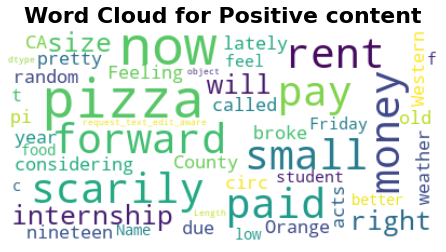

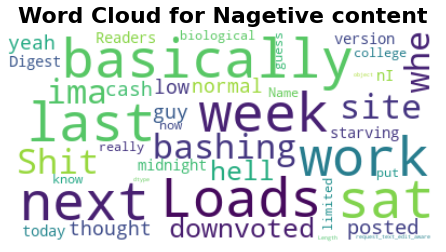

In [155]:
mpl.rcParams['font.size']=12        
mpl.rcParams['savefig.dpi']=100         
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_positive['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Positive content",fontsize=22, fontweight='bold')
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_negative['request_text_edit_aware']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Nagetive content",fontsize=22, fontweight='bold')
plt.show()

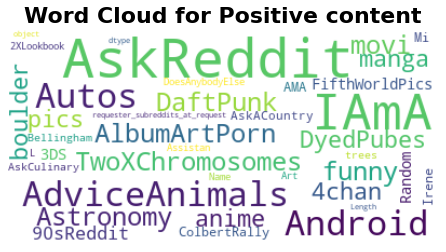

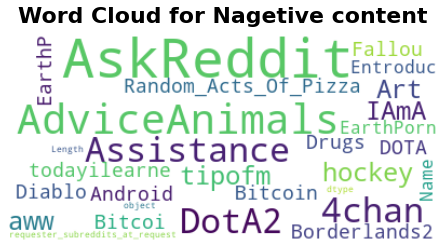

In [156]:
mpl.rcParams['font.size']=12        
mpl.rcParams['savefig.dpi']=100         
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_positive['requester_subreddits_at_request']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Positive content",fontsize=22, fontweight='bold')
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_negative['requester_subreddits_at_request']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Nagetive content",fontsize=22, fontweight='bold')
plt.show()

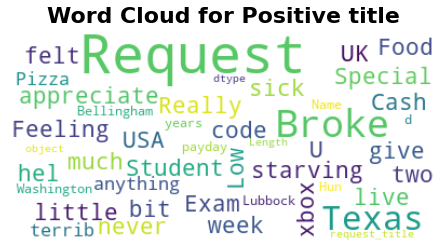

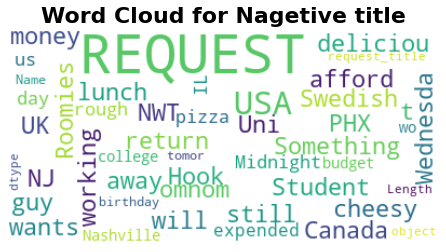

In [157]:
mpl.rcParams['font.size']=12        
mpl.rcParams['savefig.dpi']=100         
mpl.rcParams['figure.subplot.bottom']=.1 

stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_positive['request_title']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Positive title",fontsize=22, fontweight='bold')
plt.show()

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(train_negative['request_title']))

fig = plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.title("Word Cloud for Nagetive title",fontsize=22, fontweight='bold')
plt.show()

# Model based on numerical/categorical only
> following sections will be models based solely on the numerical/catgeorical data

## Uniform Random Reject
> model outcome based on a 50/50 coin flip

In [405]:
random_uniform_reject = [0]*int(len(test_labels['requester_received_pizza'])/2) + [1]*int(len(test_labels['requester_received_pizza'])/2)
np.random.shuffle(random_uniform_reject)
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=random_uniform_reject))

              precision    recall  f1-score   support

       False       0.76      0.51      0.61       602
        True       0.27      0.53      0.36       206

    accuracy                           0.52       808
   macro avg       0.52      0.52      0.49       808
weighted avg       0.64      0.52      0.55       808



## Always Reject
> a model that always predict to refuse to give pizza

In [406]:
always_reject = [0]*len(test_labels['requester_received_pizza'])
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=always_reject))

              precision    recall  f1-score   support

       False       0.75      1.00      0.85       602
        True       0.00      0.00      0.00       206

    accuracy                           0.75       808
   macro avg       0.37      0.50      0.43       808
weighted avg       0.56      0.75      0.64       808



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN
> a model uses knn with tuning

In [407]:
model_knn = KNeighborsClassifier(algorithm='brute')
parameters = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15, 17]}
clf = GridSearchCV(
    estimator=model_knn,
    param_grid=parameters, cv=5, scoring='f1_macro')
clf.fit(train_data_regression, train_labels['requester_received_pizza'])
print("Best k = ", clf.best_params_)

model_knn = KNeighborsClassifier(n_neighbors=clf.best_params_['n_neighbors'])
model_knn.fit(train_data_regression, train_labels['requester_received_pizza'])
# predict on the dev data
model_knn_prediction = model_knn.predict(test_data_regression)
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=model_knn_prediction))

Best k =  {'n_neighbors': 3}
              precision    recall  f1-score   support

       False       0.77      0.66      0.71       602
        True       0.29      0.41      0.34       206

    accuracy                           0.60       808
   macro avg       0.53      0.53      0.52       808
weighted avg       0.64      0.60      0.62       808



In [408]:
model_knn_train_prediction = model_knn.predict(train_data_regression)

## Regression
> a model uses regression with tuning

In [409]:
model_regression = LogisticRegression(solver="liblinear")
Cs = list(np.logspace(-4, 4, 20))
parameters = {'C':Cs}
clf = GridSearchCV(
    estimator=model_regression,
    param_grid=parameters, cv=5, scoring='f1_macro')
clf.fit(train_data_regression, train_labels['requester_received_pizza'])
print("Best C = ", clf.best_params_)

model_regression = LogisticRegression(C=clf.best_params_['C'], solver="liblinear")
model_regression.fit(train_data_regression, train_labels['requester_received_pizza'])
# predict on the dev data
model_regression_prediction = model_regression.predict(test_data_regression)
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=model_regression_prediction))

Best C =  {'C': 0.03359818286283781}
              precision    recall  f1-score   support

       False       0.82      0.65      0.73       602
        True       0.36      0.58      0.45       206

    accuracy                           0.63       808
   macro avg       0.59      0.62      0.59       808
weighted avg       0.70      0.63      0.65       808



In [410]:
model_regression_train_prediction = model_regression.predict(train_data_regression)

## Random Forest
> a model uses rf with tuning

In [411]:
# Random Forest
model_rf = RandomForestClassifier()
n_estimators = list(range(10,101,10))
max_features = list(range(6,len(train_data_regression.columns),2))
parameters = {'n_estimators':n_estimators, 'max_features':max_features}
clf = GridSearchCV(
    estimator=model_rf,
    param_grid=parameters, cv=5, scoring='f1_macro')
clf.fit(train_data_regression, train_labels['requester_received_pizza'])
print("Best Params = ", clf.best_params_)

model_rf = RandomForestClassifier(n_estimators=clf.best_params_['n_estimators'], max_features=clf.best_params_['max_features'])
model_rf.fit(train_data_regression, train_labels['requester_received_pizza'])
# predict on the dev data
model_rf_prediction = model_rf.predict(test_data_regression)
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=model_rf_prediction))

Best Params =  {'max_features': 6, 'n_estimators': 80}
              precision    recall  f1-score   support

       False       0.77      0.91      0.83       602
        True       0.42      0.20      0.27       206

    accuracy                           0.73       808
   macro avg       0.59      0.55      0.55       808
weighted avg       0.68      0.73      0.69       808



In [412]:
model_rf_train_prediction = model_rf.predict(train_data_regression)

## Xgboost
> a model uses xgboost with tuning

In [415]:
data_dmatrix = xgb.DMatrix(data=train_data_regression,label=train_labels)

In [416]:
params={
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform ('gamma', 1,9),
    'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
    'reg_lambda' : hp.uniform('reg_lambda', 0,1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'seed': 4444
}

In [417]:
def objective(params):
    params = {
        'objective':'binary:logistic',
        'colsample_bytree': int(params['colsample_bytree']),
        'learning_rate': 0.1,
        'max_depth': int(params['max_depth']),
        'alpha': 10,
        'reg_alpha' : int(params['reg_alpha']),
        'reg_lambda' : int(params['reg_lambda']),
        'min_child_weight' : int(params['min_child_weight']),
        'gamma': params['gamma']
    }

    cv_result = xgb.cv(
        dtrain=data_dmatrix,
        params=params,
        nfold=5,
        num_boost_round=50,
        early_stopping_rounds=10,
        metrics="logloss",
        as_pandas=True,
        seed=4444
    )
    
    # print ("Score:", cv_result.tail(1)['test-logloss-mean'])
    return {'loss': cv_result.tail(1)['test-logloss-mean'], 'status': STATUS_OK }

In [418]:
trials = Trials()

best_hyperparams = fmin(
    fn = objective,
    space = params,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials
)


100%|██████████| 100/100 [00:26<00:00,  3.82trial/s, best loss: 0.6717580000000001]


In [419]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])
best_hyperparams['reg_alpha'] = int(best_hyperparams['reg_alpha'])

In [420]:
base_params = {
    'objective':'binary:logistic',
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators':180,
}

params = dict(base_params, **best_hyperparams)           
xgb_clf = XGBClassifier(**params)
xgb_clf.fit(train_data_regression, train_labels)

[08:29:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5509356448158516,
              gamma=1.1934814605043051, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=1.0, max_delta_step=0,
              max_depth=6, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=180, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=40,
              reg_lambda=0.4344059843941709, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [421]:
model_xgb_prediction = xgb_clf.predict(test_data_regression)

In [422]:
print(classification_report(y_true=test_labels['requester_received_pizza'], y_pred=model_xgb_prediction))

              precision    recall  f1-score   support

       False       0.80      0.67      0.73       602
        True       0.35      0.51      0.41       206

    accuracy                           0.63       808
   macro avg       0.57      0.59      0.57       808
weighted avg       0.68      0.63      0.65       808



In [423]:
model_xgb_train_prediction = xgb_clf.predict(train_data_regression)

# Machine Learning with Transformers

## Train/Test data with only text

In [459]:
# prep the train/test data
df_train = pd.DataFrame()
df_train['text'] = train_data['request_title'] + " " + train_data['request_text_edit_aware']
df_train['labels'] = train_labels['requester_received_pizza'].astype(int)
df_test = pd.DataFrame()
df_test['text'] = test_data['request_title'] + " " + test_data['request_text_edit_aware']
df_test['labels'] = test_labels['requester_received_pizza'].astype(int)

## Preprocess Text

In [460]:
def preprocessor(s):
    # mask email
    s = re.sub('[a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+', ' EMAIL ', s)
    
    # replace link
    s = re.sub('https?://\S+', ' LINK ', s, flags=re.MULTILINE)
    
    # make _ and / as spaces
    s = re.sub('_+', ' ', s)
    s = re.sub('/+', ' ', s)
    
    # mask number
    s = re.sub('\d+', ' NUMBER ', s)
    
    # removing various non-letter characters but keep dash and dots and @
    s = re.sub('[^A-Za-z0-9\s\-\.@]+', '', s)
    
    # have a min word length but also keep abbrieviations
#     words = s.split(" ")
#     min_size = 3
#     s = " ".join([(word.lower() if len(word)>min_size else (word if word.lower()!=word else ""))  for word in words])
    
    return s

In [461]:
# do preprocessing on the response level data
df_train['text'] = df_train['text'].apply(lambda x: preprocessor(x))
df_test['text'] = df_test['text'].apply(lambda x: preprocessor(x))

In [462]:
# do sentence tokenization
df_train_sent = df_train.copy(deep=False)
df_train_sent['text'] = df_train['text'].apply(lambda x: sent_tokenize(x))
df_train_sent = df_train_sent.reset_index().explode('text')
df_train_sent = df_train_sent.sample(frac=1, random_state=9999)

In [463]:
df_test_sent = df_test.copy(deep=False)
df_test_sent['text'] = df_test['text'].apply(lambda x: sent_tokenize(x))
df_test_sent = df_test_sent.reset_index().explode('text')
df_test_sent = df_test_sent.sample(frac=1, random_state=9999)

## Build the model

In [160]:
# check some examples
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):  # more options can be specified also
    display(df_train_sent.head())

,index,text,labels
835,1422,-Cant find a fucking job.,1
1465,535,My friend in Aberystwyth has several thousand words to write tonight but shes got no money ran out of rice and lentils yesterday and doesnt get her student loan until tomorrow.,1
3374,3580,Thanks for those who read this post.,0
2655,3334,Thank you everyone\n\nNote This account is new but I can contact you from my older account if you want.,0
684,736,Request Bank account frozen-no food in the house-spent last bit of money on formula for my son.,1


## Use this ONLY to load trained models

In [36]:
# for loading pretrained models only
sent_model = ClassificationModel('roberta', model_name='matching_model_class_weight_outputs', args=training_args, use_cuda=True)

## Sentence Based Model
> This model breaks down the responses into sentences then combines the score back to response level score

In [175]:
# an arbiturary set of hypter parameters.
def get_args():
    """Return a dictionary that can be passed into the model trainng function."""
    args = {
        "output_dir": "sent_model_class_weight_outputs/",
        "cache_dir": "sent_model_class_weight_cache_dir/",
        
        "fp16": True,
        "fp16_opt_level": "O1",
        "max_seq_length": 256,
        "train_batch_size": 32,
        "gradient_accumulation_steps": 4,
        "eval_batch_size": 128,
        "num_train_epochs": 3,
        "weight_decay": 0,
        "learning_rate": 5e-5, 
        "adam_epsilon": 1e-8,
        "warmup_ratio": 0.06,
        "warmup_steps": 0,
        "max_grad_norm": 1.0,

        "logging_steps": 50,
        "save_steps": 2000,

        "overwrite_output_dir": True,
        "reprocess_input_data": False,
        "evaluate_during_training": False,

        "process_count": 1,
        "n_gpu": 1
    }
    return args
training_args = get_args()

In [23]:
# use xlnet base cased model for transfer leraning
sent_model = ClassificationModel('roberta', 'roberta-base', args=training_args, use_cuda=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.

In [39]:
# train on the shuffled sample
torch.cuda.empty_cache()
sent_model.train_model(df_train_sent[['text','labels']].sample(frac=1, random_state=9999))

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:936: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


(612, 0.2830584016552475)

In [424]:
report, model_outputs, wrong_predictions = sent_model.eval_model(df_test_sent[['text', 'labels']])
report

{'mcc': 0.049096578413491555,
 'tp': 461,
 'tn': 2002,
 'fp': 961,
 'fn': 767,
 'auroc': 0.5454988561421483,
 'auprc': 0.3350888975220092,
 'eval_loss': 1.3379598025119666}

## Combine sentences

In [464]:
sent_test_predictions, sent_test_raw_outputs = sent_model.predict(list(df_test_sent['text'].values))
sent_train_predictions, sent_train_raw_outputs = sent_model.predict(list(df_train_sent['text'].values))

In [465]:
df_test_sent_prep = df_test_sent.copy()
df_test_sent_prep['pred'] = sent_test_predictions
df_test_sent_prep['pred_score_diff'] = sent_test_raw_outputs[:,1] - sent_test_raw_outputs[:,0]

In [466]:
df_train_sent_prep = df_train_sent.copy()
df_train_sent_prep['pred'] = sent_train_predictions
df_train_sent_prep['pred_score_diff'] = sent_train_raw_outputs[:,1] - sent_train_raw_outputs[:,0]

In [467]:
def agg_labels(pred, pred_score_diff):
    pred = list(pred)
    pred_score_diff = list(pred_score_diff)
    mean_pred = pred[0]
    mean_pred_score_diff = pred_score_diff[0]
    
    # the prediction labels should be majority vote
    # since the labels are just 0 and 1, we can check the mean against 0.5
    if len(pred)>1:
        mean_pred = np.mean(pred)
        mean_pred_score_diff = np.mean(pred_score_diff)

    
    # if there's a tie, check the actual scores to resolve the tie
    # tie occurs when the diff in score is 0
    # to adhere to what we had before, add the offset 0.5 to it
    if mean_pred == 0.5:
        mean_pred = mean_pred_score_diff + 0.5
        
    # if there's still a tie, assume winning
    out_pred = 1 if mean_pred >= 0.5 else 0
    return out_pred
    
    
    

In [468]:
df_test_sent_agg = pd.DataFrame()
df_test_sent_agg['labels'] = df_test_sent_prep.groupby(['index']).apply(lambda row_list: list(row_list['labels'])[0])
df_test_sent_agg['pred'] = df_test_sent_prep.groupby(['index']).apply(lambda row_list: agg_labels(pred=list(row_list['pred']), pred_score_diff=list(row_list['pred_score_diff'])))

In [469]:
df_train_sent_agg = pd.DataFrame()
df_train_sent_agg['labels'] = df_train_sent_prep.groupby(['index']).apply(lambda row_list: list(row_list['labels'])[0])
df_train_sent_agg['pred'] = df_train_sent_prep.groupby(['index']).apply(lambda row_list: agg_labels(pred=list(row_list['pred']), pred_score_diff=list(row_list['pred_score_diff'])))

In [470]:
print(classification_report(y_true=df_test_sent_agg['labels'], y_pred=df_test_sent_agg['pred']))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       602
           1       0.32      0.28      0.30       206

    accuracy                           0.66       808
   macro avg       0.54      0.54      0.54       808
weighted avg       0.65      0.66      0.66       808



In [471]:
df_train_sent_agg.reset_index(inplace=True, drop=True)
df_test_sent_agg.reset_index(inplace=True, drop=True)

## Response Level Model

In [434]:
# an arbiturary set of hypter parameters.
def get_args():
    """Return a dictionary that can be passed into the model trainng function."""
    args = {
        "output_dir": "response_model_class_weight_outputs/",
        "cache_dir": "response_model_class_weight_cache_dir/",
        
        "fp16": True,
        "fp16_opt_level": "O1",
        "max_seq_length": 256,
        "train_batch_size": 16,
        "gradient_accumulation_steps": 8,
        "eval_batch_size": 128,
        "num_train_epochs": 3,
        "weight_decay": 0,
        "learning_rate": 8e-5, 
        "adam_epsilon": 1e-8,
        "warmup_ratio": 0.06,
        "warmup_steps": 0,
        "max_grad_norm": 1.0,

        "logging_steps": 50,
        "save_steps": 2000,

        "overwrite_output_dir": True,
        "reprocess_input_data": False,
        "evaluate_during_training": False,

        "process_count": 1,
        "n_gpu": 1
    }
    return args

In [177]:
# use xlnet base cased model for transfer leraning
matching_model = ClassificationModel('roberta', 'roberta-base', args=training_args, use_cuda=True)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.

In [184]:
# train on the shuffled sample
torch.cuda.empty_cache()
matching_model.train_model(df_train.sample(frac=1, random_state=9999))

/opt/conda/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:936: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm


(114, 0.335298526803391)

In [436]:
response_test_predictions, response_test_raw_outputs = matching_model.predict(list(df_test['text'].values))
response_train_predictions, response_train_raw_outputs = matching_model.predict(list(df_train['text'].values))

In [437]:
print(classification_report(y_true=df_test['labels'], y_pred=response_test_predictions))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76       602
           1       0.33      0.36      0.34       206

    accuracy                           0.65       808
   macro avg       0.55      0.55      0.55       808
weighted avg       0.66      0.65      0.65       808



## Leveraging additional subreddit information
> now instead of just the titles/body, we also add the topics of subreddits to account

In [438]:
def join_reddits(s):
    return " ".join(s)

In [439]:
#('requester_subreddits_at_request_idf',OneHotEncoder(dtype='int', handle_unknown='ignore'), 'requester_subreddits_at_request'),
text_columns = ['request_text_edit_aware', 'request_title','requester_subreddits_at_request']
train_data_text = train_data[text_columns]
train_data_text['requester_subreddits_at_request']=train_data_text['requester_subreddits_at_request'].apply(join_reddits)
train_data_test = test_data[text_columns]
train_data_test['requester_subreddits_at_request']=train_data_test['requester_subreddits_at_request'].apply(join_reddits)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [440]:
df_result_train = pd.DataFrame()
df_result_test = pd.DataFrame()

## KNN only text data 
> a knn model with additional subreddit information

In [441]:
MAX_FEAT_DESCP = 50000
text_columns = ['request_text_edit_aware', 'request_title', 'requester_subreddits_at_request']
preprocess = ColumnTransformer(
    [('request_title_idf', TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'request_title'),
     ('requester_subreddits_at_request_idf',TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'requester_subreddits_at_request'),
     ('request_text_edit_aware_idf', TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'request_text_edit_aware')],
    remainder='passthrough')

grid_params = {
    'n_neighbors':[3,5,11,19],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}

model = make_pipeline(
    preprocess,
    GridSearchCV(KNeighborsClassifier(),
                grid_params,
                verbose=3,
                cv=3,
                scoring='recall',
                n_jobs=-1))
    
model.fit(train_data_text, train_labels)

y_train_pred = model.predict(train_data_text)
df_result_train['knn_text'] = y_train_pred
y_pred = model.predict(train_data_test)
df_result_test['knn_text'] = y_pred

print(classification_report(test_labels, y_pred))

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

       False       0.77      0.88      0.82       602
        True       0.37      0.21      0.27       206

    accuracy                           0.71       808
   macro avg       0.57      0.55      0.54       808
weighted avg       0.67      0.71      0.68       808



## Regression only text data
> a regression model with addtional subreddit information

In [442]:
MAX_FEAT_DESCP = 50000
text_columns = ['request_text_edit_aware', 'request_title', 'requester_subreddits_at_request']
preprocess = ColumnTransformer(
    [('request_title_idf', TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'request_title'),
     ('requester_subreddits_at_request_idf',TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'requester_subreddits_at_request'),
     ('request_text_edit_aware_idf', TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'request_text_edit_aware')],
    remainder='passthrough')
Cs = list(np.logspace(-4, 4, 20))
grid_params = {'C':Cs}
model = make_pipeline(
    preprocess,
    GridSearchCV(LogisticRegression(solver="liblinear"),
                grid_params,
                verbose=3,
                cv=3,
                scoring='f1',
                n_jobs=-1))
    
model.fit(train_data_text, train_labels)

y_train_pred = model.predict(train_data_text)
df_result_train['regression_text'] = y_train_pred
y_pred = model.predict(train_data_test)
df_result_test['regression_text'] = y_pred

print(classification_report(test_labels, y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

       False       0.75      0.94      0.84       602
        True       0.33      0.08      0.13       206

    accuracy                           0.72       808
   macro avg       0.54      0.51      0.48       808
weighted avg       0.64      0.72      0.66       808



## Ensemble numerical and text model
> combines all the models together

In [478]:
# combine previous text/numerical models
df_result_train['roberta'] = response_train_predictions.astype(bool)
df_result_test['roberta'] = response_test_predictions.astype(bool)
df_result_train['rf_numerical'] = model_rf_train_prediction
df_result_test['rf_numerical'] = model_rf_prediction
df_result_train['regression_numerical'] = model_regression_train_prediction
df_result_test['regression_numerical'] = model_regression_prediction
df_result_train['knn_numerical'] = model_knn_train_prediction
df_result_test['knn_numerical'] = model_knn_prediction
df_result_train['xgb_numerical'] = model_xgb_train_prediction
df_result_test['xgb_numerical'] = model_xgb_prediction
# df_result_train['roberta_sent'] = df_train_sent_agg['pred']
# df_result_test['roberta_sent'] = df_test_sent_agg['pred']

test_labels = test_labels.reset_index(drop=True)

In [582]:
models_to_ensemble = [
#     'regression_text',
    'knn_text',
    'roberta',
    'rf_numerical',
    'regression_numerical',
    'knn_numerical',
    'xgb_numerical'
]

### linear regression ensemble

In [591]:
X = df_result_train[models_to_ensemble]
Y = train_labels
penalty = ['l1', 'l2']
Cs = list(np.logspace(-4, 4, 20))
grid_params = {'C':Cs,'penalty':penalty}
clf_GS = GridSearchCV(LogisticRegression(solver="liblinear"),
                grid_params,
                verbose=3,
                cv=3,
                scoring='recall',
                n_jobs=-1)
clf_GS.fit(X,Y)
print('Best Penalty:', clf_GS.best_estimator_.get_params()['penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['C'])
lrmodel = LogisticRegression(C=clf_GS.best_estimator_.get_params()['C'],penalty=clf_GS.best_estimator_.get_params()['penalty'])
lrmodel.fit(X,Y)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Penalty: l2
Best C: 0.0001


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LogisticRegression(C=0.0001)

In [600]:
ensemble_predict = lrmodel.predict(df_result_test[models_to_ensemble])
print(classification_report(test_labels['requester_received_pizza'], ensemble_predict))

              precision    recall  f1-score   support

       False       0.77      0.92      0.84       602
        True       0.44      0.19      0.26       206

    accuracy                           0.73       808
   macro avg       0.60      0.55      0.55       808
weighted avg       0.68      0.73      0.69       808



### Majority Vote Ensemble

In [601]:
test_labels['pred'] = df_result_test.apply(lambda row: np.mean(row[models_to_ensemble].tolist())>=0.5, axis=1)

In [602]:
print(classification_report(test_labels['requester_received_pizza'], test_labels['pred']))

              precision    recall  f1-score   support

       False       0.80      0.78      0.79       602
        True       0.41      0.45      0.43       206

    accuracy                           0.70       808
   macro avg       0.61      0.61      0.61       808
weighted avg       0.70      0.70      0.70       808

